In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from datetime import timedelta
import collections
import PIL
from PIL import Image

In [3]:
tf.__version__

'1.9.0'

In [4]:
#Resize the images in this much size
img_hieght = 100
img_width = 100

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_hieght * img_width

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_hieght, img_width)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each letter(26 small letters + 26 capital letters + 10 digits)
num_classes = 62

In [5]:
import re, os, cv2
from glob import glob

def create_argmax(folder_name):
    #index = re.search('Sample(.*)', folder_name).group(1)
    #print(index) - 001 for folder_name = 'Sample001'
    index = int(re.search('Sample(.*)', folder_name).group(1)) - 1
    arr = np.zeros(num_classes)
    arr[index] = 1
    return arr

def ConvertImageToNpArray(path):
    img = cv2.imread(path)
    img = cv2.resize(img, dsize=(img_shape), interpolation=cv2.INTER_CUBIC)
    #print(img.shape)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).reshape(10000).astype(np.float32, copy=False)    

#Demo
print(create_argmax('Sample001'))

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
import cv2
i = 0
def get_dataset():
    DATASET_LOCATION = 'English/Hnd/Img'
    #DATASET_LOCATION = 'Common'
    hcr = {'data':[], 'labels':[], 'cls':[]}
    for folder in glob(DATASET_LOCATION + '/*'):
            if os.path.isdir(folder):            
                for img_path in glob(folder + '/*.png'): 
                    hcr.get('data').append(ConvertImageToNpArray(img_path))
                    hcr.get('labels').append(create_argmax(folder))
                    hcr.get('cls').append(int(folder[-3:]) - 1)
                    #print(hcr['cls'])
    print('Done')
    # shuffle data
    permutate = np.random.permutation(len(hcr.get('data')))
    return {k1:v1[permutate] for k1, v1 in {k: np.array(v) for k, v in hcr.items()}.items()}

hcr = get_dataset()

In [7]:
print(hcr.get('data').shape)

(3410, 10000)


# Helper-function for plotting images

In [8]:
#Function to plot images
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

In [9]:
sess = tf.Session()

# Plot a few images to see if data is correct

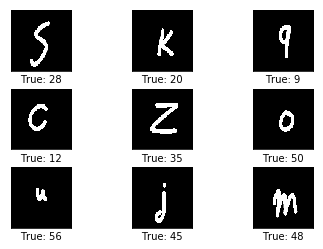

In [10]:
# Get the images from the test-set.
images = hcr.get('data')[1000:1009]

# Get the true classes for those images.
cls_true = hcr.get('cls')[1000:1009]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

# Model

In [34]:
#Layers of neural network
n_input = 10000
n_hidden_1 = 700
n_hidden_2 = 700
n_classes = num_classes

#Initialising weights and biases with random numbers
weights = {
    'h1' : tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2' : tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out' : tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}

biases = {
    'h1' : tf.Variable(tf.random_normal([n_hidden_1])),
    'h2' : tf.Variable(tf.random_normal([n_hidden_2])),
    'out' : tf.Variable(tf.random_normal([n_classes]))
}

In [35]:
#Forward propagation
def forward_propagation(x, weights, biases):
    in_layer1 = tf.add(tf.matmul(x, weights['h1']), biases['h1'])
    out_layer1 = tf.nn.relu(in_layer1)
    in_layer2 = tf.add(tf.matmul(out_layer1, weights['h2']), biases['h2'])
    out_layer2 = tf.nn.relu(in_layer2)
    output = tf.add(tf.matmul(out_layer2, weights['out']), biases['out'])
    return output

In [36]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
x = tf.placeholder('float', [None, n_input])
y = tf.placeholder('int32', [None, n_classes])

In [37]:
#Finding Predictions and Accuracy
pred = forward_propagation(x, weights, biases)
#Finding index of max. value
predictions = tf.argmax(pred, axis = 1)
#Actual output
true_labels = tf.argmax(y, 1)
correct_predictions = tf.equal(predictions, true_labels)

In [38]:
#Predictions
predictions_eval = sess.run(predictions, feed_dict = {x:hcr['data']})
print(predictions_eval.shape)
predictions_eval

(3410,)


array([38, 38, 39, ..., 39, 39, 39], dtype=int64)

In [39]:
#Actual output 
correct_labels = sess.run(true_labels, feed_dict = {y:hcr['labels']})
print(correct_labels.shape)
correct_labels

(3410,)


array([49, 37, 20, ...,  6,  5, 39], dtype=int64)

In [40]:
predictions_eval,labels, correct_pred  = sess.run([predictions, true_labels, correct_predictions], feed_dict={x:hcr['data'], y:hcr['labels']})
predictions_eval,labels,correct_pred

(array([38, 38, 39, ..., 39, 39, 39], dtype=int64),
 array([49, 37, 20, ...,  6,  5, 39], dtype=int64),
 array([False, False, False, ..., False, False,  True]))

In [41]:
correct_pred = sess.run(correct_predictions, feed_dict={x:hcr['data'], y:hcr['labels']})
print(correct_pred)
#No. of correct predictions out of 3410
correct_pred.sum()

[False False False ... False False  True]


58

In [42]:
#Cost function
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = pred, labels = y))
cost

<tf.Tensor 'Mean_1:0' shape=() dtype=float32>

In [43]:
#Running the optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
optimize = optimizer.minimize(cost)

In [44]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [45]:
c1 = sess.run(cost, feed_dict={x:hcr['data'], y:hcr['labels']})
print(c1)
#c2 = sess.run(cost, feed_dict={x:mnist.test.images, y:mnist.test.labels})
#print(c2)

18603020.0


In [46]:
#After running the optimizer
for i in range(1000):
    c, _ = sess.run([cost,optimize], feed_dict={x:hcr['data'], y:hcr['labels']})
    print(c)

18603020.0
14215728.0
12254926.0
10559172.0
9957900.0
9334533.0
8773663.0
8143338.0
7600481.5
7187546.0
6813567.0
6277049.0
5837947.0
5423540.5
5169525.0
4946220.5
4791421.0
4601153.5
4376642.5
4175021.0
4042836.5
3962147.0
3859999.5
3760627.0
3672319.2
3561630.0
3458398.8
3362718.5
3263692.8
3177787.5
3087077.5
2992052.2
2911936.8
2858836.2
2830882.5
2818960.2
2807248.8
2761056.5
2698613.2
2646963.8
2595862.2
2542214.0
2498465.5
2461031.2
2431262.8
2410286.0
2385150.0
2349493.0
2314001.0
2279905.0
2250004.2
2222939.2
2194629.2
2166029.8
2142078.0
2124680.5
2108588.0
2092821.9
2077102.9
2059927.4
2039955.5
2019620.0
2001398.1
1985279.8
1968620.8
1953557.0
1941315.0
1928449.5
1914041.6
1898878.2
1883509.6
1869198.6
1856488.8
1843545.0
1830467.0
1817889.4
1806336.1
1794780.8
1782416.5
1770192.0
1758242.4
1746461.8
1735314.2
1724193.1
1713156.8
1702262.9
1691370.4
1680994.8
1670295.8
1659666.1
1649266.8
1638785.1
1628376.8
1617899.2
1607538.8
1597664.6
1587454.0
1577685.6
1567996.1
155829

67053.625
66830.7
66686.31
67211.19
67660.65
68409.945
67607.53
66387.46
66734.03
67577.55
67216.93
66695.09
68421.65
70654.97
74016.84
74381.38
73426.07
72189.86
76371.58
73753.1
71929.33
72104.44
76837.05
76790.41
81019.34
74651.72
69649.46
76605.72
72415.14
77330.195
71796.02
76274.32
70204.86
71018.12
66729.37
67413.0
68462.66
67634.06
67557.18
64920.598
66011.54
63215.58
66008.06
60009.78
62780.707
61722.465
60380.75
61398.816
57125.527
58057.65
58105.67
56649.496
59119.043
54942.156
57113.355
56205.43
54606.65
55822.367
52861.203
54940.316
55921.0
54145.92
57464.598
57189.39
54713.85
57580.48
58349.02
59231.98
59071.074
63163.57
60595.844
60166.93
59241.94
60913.355
54026.99
57183.145
52716.555
53173.195
54686.902
51915.43
50887.727
51070.105
51258.27
50411.28
49803.758
48537.195
49375.746
49462.477
49107.496
49071.598
48438.324
47902.574
47910.812
46753.594
45799.0
46896.855
45798.156
44495.785
45521.113
46655.703
46602.324
44367.805
45748.633
43438.633
43079.316
42977.8
42954.8

In [47]:
predictions_eval,labels, correct_pred  = sess.run([predictions, true_labels, correct_predictions], feed_dict={x:hcr['data'],
                                                                                                              y:hcr['labels']})
predictions_eval,labels,correct_pred

(array([49, 37, 50, ...,  6, 44, 39], dtype=int64),
 array([49, 37, 20, ...,  6,  5, 39], dtype=int64),
 array([ True,  True, False, ...,  True, False,  True]))

In [48]:
#Now the accuracy has been improved
predictions = tf.argmax(pred, 1)
correct_labels = tf.argmax(y, 1)
correct_predictions = tf.equal(predictions, correct_labels)
predictions,correct_predictions  = sess.run([predictions, correct_predictions], feed_dict={x:hcr['data'], y:hcr['labels']})
correct_predictions.sum()

2699